# This sage worksheet accompanies my paper  (joint with Abhishek Saha and Kęstutis Česnavičius)
# <p style="text-align: center;"> ['The Manin constant and the modular degree'](https://arxiv.org/abs/1911.09446) </p>

# Plotting data from the Cremona database
To illustrate the strength of one of our main theorems, Theorem 1.2, we produce various plots from the Cremona database. The data here was used to produce the first plot in our paper (page 3). For a finite set $S$ of primes and every conductor $N<300000$ we count the proportions of three sets of elliptic curves: 

1. Curves that are semistable away from $S$.
2. Curves where Theorem 1.2 eliminates all additive primes away from $S$.
3. Curves where Theorem 1.2 eliminates at least one additive prime not in $S$.

In the following we choose the sets $S=\emptyset$, $S=\{2\}$, and $S=\{2,3\}$. Note that this worksheet grew gradually during our project. Instead of rewriting the code, I often added code for all three choices of $S$. That's why all functions and data exist three times, once without suffix (corresponding to $S=\emptyset$), once with the suffix '_odd' (corresponding to $S=\{2\}$), and once with the suffix 'disregard_2_3' (corresponding to $S=\{2,3\}$). This is really not elegant and I plan to change it.

### <font color ="green"> Requirements: SageMath</font>

In [4]:
#Initiate the data first. If the file cremona_data_3000000 does not exist you can instead run
# c,L = load_optimal_curves(bound=300000)
c, L = load('cremona_data_300000')

In [20]:
data,conductors,cond_coprime_to_m=load('ell_curve_data')

In [21]:
data_odd,conductors_odd,cond_coprime_to_m_odd = load('ell_curve_data_odd')

In [22]:
data_disregard_2_3,conductors_disregard_2_3,cond_coprime_to_m_disregard_2_3 = load('ell_curve_data_disregard_2_3')

In [ ]:
from random import uniform
import time
from IPython.display import display, clear_output

def load_optimal_curves(bound=10000):
    #Load optimal curves for cremona database to insert into produce_data
    c = CremonaDatabase()
    L = [e.cremona_label() for e in CremonaDatabase().iter_optimal([11..bound])]
    return c,L

def produce_data(c,L,bound=10000,exclude=[]):
    #For bound=300000 I saved the output in ell_curve_data.sobj
    #exclude is a list of primes to exclude from our study.
    data = len(L)*[0]
    conductors = len(L)*[0]
    cond_coprime_to_m = len(L)*[0] #Set to 1 if all additive primes are coprime to the modular degree
    rat_sing_counter=0
    for k in range(len(L)):
        clear_output(wait=True)
        display('NEW k! It is ', k)
        display('Cremona label', L[k])
        E = c.elliptic_curve(L[k])
        N = E.conductor()
        m = E.modular_degree()
        conductors[k] = N
        N_divs = N.prime_divisors()
        Np = prod([p^valuation(N,p) for p in N_divs if valuation(N,p)>1 and (not p in exclude)])
        """We set data[k] to
        1: if N is squarefree away from the set exclude
        2: if all additive primes not in exclude are eliminated by our Theorem
        3: if one additive prime not in exclude is eliminated by our Theorem
        0: if none of the above happens
        """
        if Np == 1:
            data[k] = 1
            display('sqfree')
            continue
        if gcd(Np,m)==1:
            cond_coprime_to_m[k]=1
        additive_primes = Np.prime_divisors()
        bounds = [valuation(m,p) for p in additive_primes]
        display('calculated bound')
        if valuation(Np,2)>=3 and len([q for q in N_divs if q%4==3])==0:
            bounds[additive_primes.index(2)] += 1
            rat_sing_counter+=1
        if valuation(Np,3)>=3 and len([q for q in N_divs if q%3==2])==0:
            bounds[additive_primes.index(3)] += 1
        if max(bounds)==0:
            print display('we prove conj')
            data[k]=2
            continue
        if min(bounds)==0:
            print display('eliminated one additive prime')
            data[k]=3
            continue
    return [L,data,conductors,cond_coprime_to_m,rat_sing_counter]
def a1(x, L=data):
    return L[:floor(x)].count(1)/(floor(x)+1)
def a2(x, L=data):
    return L[:floor(x)].count(2)/(floor(x)+1)
def a3(x, L=data):
    return L[:floor(x)].count(3)/(floor(x)+1)
def a4(x, L=data):
    return L[:floor(x)].count(4)/(floor(x)+1)
def a1pa2(x, L=data):
    return a1(x, L)+a2(x, L)
def a1pa2pa3(x, L=data):
    return a1(x, L)+a2(x, L)+a3(x, L)
def a1pa2pa3pa4(x, L=data):
    return a1(x, L)+a2(x, L)+a3(x, L)+a4(x, L)
def produce_plots(until):
    #cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([a1,a1pa2,a1pa2pa3],0,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=.6,\
             fillalpha=1,fillcolor=cols,ticks=[[59503,214201,437226,658895,876914,1095565,1311066],srange(0,.8,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(8)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.08,.13],[.28,.33],[.48,.53], [.68,.73]]
    polygons=[]
    texts=[]
    descriptions=['All primes are semistable', 'Theorem eliminates\nall additive primes',\
                  'Theorem eliminates\nat least one additive prime', 'The Theorem provides a new\ndivisibility statement for $c_E$']
    for i in range(3): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-45000,-.05),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(sqrt(2)))
    return p

def produce_plots_at_2(until):
    #Plot only ell curves semistable at 2
    k_at_2 = [k for k in range(len(conductors)) if valuation(conductors[k],2)<2]
    L2 = [L[k] for k in k_at_2]                                     
    data2 = [data[k] for k in k_at_2]                       
    conductors2 = [conductors[k] for k in k_at_2]
    b1 = lambda x: a1(x,data2)
    b1pb2 = lambda x: a1pa2(x,data2)
    b1pb2pb3 = lambda x: a1pa2pa3(x,data2)
    #cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([b1,b1pb2,b1pb2pb3],0,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=.8,\
             fillalpha=1,fillcolor=cols,ticks=[[37097, 130385, 262666, 392984, 520439, 647785,773429],srange(0,.8,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(8)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.15,.20],[.35,.40],[.55,.60], [.75,.80]]
    polygons=[]
    texts=[]
    descriptions=['All primes are semistable', 'Theorem eliminates\nall additive primes',\
                  'Theorem eliminates\nat least one additive prime', 'The Theorem provides a new\ndivisibility statement for $c_E$']
    for i in range(3): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-40000,-.04),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(sqrt(2)))
    return p

def produce_plots_at_2_3(until):
    #Plot only ell curves semistable at 2 and 3
    k_at_2_3 = [k for k in range(len(conductors)) if valuation(conductors[k],2)<2 and valuation(conductors[k],3)<2]
    L2_3 = [L[k] for k in k_at_2_3]                                     
    data2_3 = [data[k] for k in k_at_2_3]                       
    conductors2_3 = [conductors[k] for k in k_at_2_3]
    c1 = lambda x: a1(x,data2_3)
    c1pc2 = lambda x: a1pa2(x,data2_3)
    c1pc2pc3 = lambda x: a1pa2pa3(x,data2_3)
    #cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([c1,c1pc2,c1pc2pc3],0,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=1,\
             fillalpha=1,fillcolor=cols,aspect_ratio = 2,ticks=[[26794, 92513, 184511, 274813, 363170, 451230, 537688],srange(0,1,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(10)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.09,.14],[.29,.34],[.49,.54], [.69,.74]]
    polygons=[]
    texts=[]
    descriptions=['All primes are semistable', 'Theorem eliminates\nall additive primes',\
                  'Theorem eliminates\nat least one additive prime', 'The Theorem provides a new\ndivisibility statement for $c_E$']
    for i in range(3): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-45000,-.05),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(sqrt(2)))
    return p

def produce_plots_odd(until):
    c1 = lambda x: a1(x,data_odd)
    c1pc2 = lambda x: a1pa2(x,data_odd)
    c1pc2pc3 = lambda x: a1pa2pa3(x,data_odd)
    #cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([c1,c1pc2,c1pc2pc3],10,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=.8,\
             fillalpha=1,fillcolor=cols,aspect_ratio = 2,ticks=[[59502,214200, 437225, 658894, 876913, 1095564, 1311065],srange(0,1,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(10)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.17,.25],[.37,.45],[.57,.65], [.69,.74]]
    polygons=[]
    texts=[]
    descriptions=['All odd primes are semistable', 'Theorem eliminates\nall odd additive primes',\
                  'Theorem eliminates\nat least one odd additive prime', 'The Theorem provides a new\ndivisibility statement for $c_E$']
    for i in range(3): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-45000,-.05),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(golden_ratio))
    return p

def produce_plots_disregard_2_3(until):
    c1 = lambda x: a1(x,data_disregard_2_3)
    c1pc2 = lambda x: a1pa2(x,data_disregard_2_3)
    c1pc2pc3 = lambda x: a1pa2pa3(x,data_disregard_2_3)
    #cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([c1,c1pc2],0,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=1,\
             fillalpha=1,fillcolor=cols,aspect_ratio = 2,ticks=[[59502, 214200, 437225, 658894, 876913, 1095564, 1311065],srange(0,1,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(10)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.25,.35],[.65,.75],[.6,.65], [.69,.74]]
    polygons=[]
    texts=[]
    descriptions=['All $p>3$ are semistable', 'Theorem eliminates\nall additive $p>3$',\
                  'Theorem eliminates\nat least one additive $p>3$', 'The Theorem provides a new\ndivisibility statement for $c_E$']
    for i in range(2): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-45000,-.05),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(golden_ratio))
    return p   

def produce_plots_ge1_ge2_ge3(until):
    b = lambda x: a1(x,data)
    g = lambda x: a1(x,data)+a2(x,data)
    y = lambda x: a1(x,data)+a2(x,data_odd)
    r = lambda x: a1(x,data)+a2(x,data_disregard_2_3)
    cols = ['#512c62','#c93838','#f75f00', '#43ab92'] #Four color Palette found on https://flatuicolors.com/palette/fr
    #cols = ['#434982','#01d28e','#ffd369'] #Three color palette found on https://colorhunt.co/
    #cols = ['#1A237C','#0288D1']
    p = plot([b,g,y,r],0,until,color=cols,fill={0:0,1:[0],2:[1],3:[2]},\
             ymin=0,ymax=.8,\
             fillalpha=1,fillcolor=cols,aspect_ratio = 2,ticks=[[59502, 214200, 437225, 658894, 876913, 1095564, 1311065],srange(0,1,0.1)],\
             tick_formatter=[['$15000$','$50000$','$100000$','$150000$','$200000$','$250000$','$300000$'],\
                             ['${}\%$'.format(10*i) for i in range(10)]])
    distance=50000 #Distance of rectangles to plot
    xsize=100000
    ys=[[.15,.45],[.55,.85],[.5,.55], [.7,.75]]
    polygons=[]
    texts=[]
    descriptions=['All primes are semistable', 'Theorem eliminates\nall additive primes',\
                  'Theorem eliminates\nall additive primes$>2$', 'Theorem eliminates\nall additive primes$>3$']
    for i in range(4): #Leave out the fourth option for the moment
        polygons.append(polygon([(until+distance,ys[i][0]),(until+distance,ys[i][1]),(until+distance+xsize,ys[i][1]),(until+distance+xsize,ys[i][0])],color=cols[i]))
        texts.append(text(descriptions[i],(until+distance+1.2*xsize,(ys[i][0]+ys[i][1])/2),color='black',horizontal_alignment='left',vertical_alignment='center'))
    p += text('$N<$',(-45000,-.05),color='black')+sum(polygons)+sum(texts)
    p.set_aspect_ratio(len(conductors)/RR(sqrt(2)))
    return p    

In [85]:
P = produce_plots_ge1_ge2_ge3(500000)

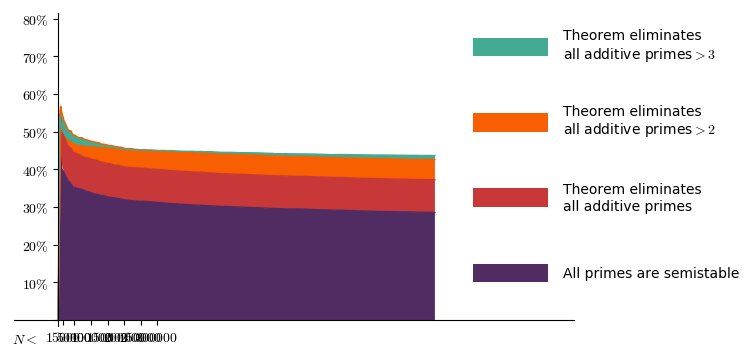

In [86]:
P.set_aspect_ratio(500000);P

In [81]:
save(P,'plot_with_info_on_C_1_2_3.eps')

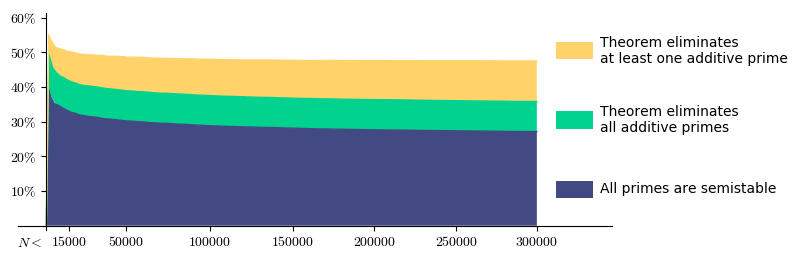

In [5]:
p=produce_plots(len(conductors)-1);p

In [6]:
save(p,'plot.eps')

In [57]:
RR(a1pa2pa3(len(data))-a1pa2(len(data))), RR(a1pa2(len(data))-a1(len(data))), RR(a1(len(data)))

(0.116984868050222, 0.0867034255305030, 0.271286669559984)

In [7]:
k_away_from_2 = [k for k in range(len(conductors)) if valuation(conductors[k],2)<2]
L2 = [L[k] for k in k_away_from_2]                                     
data2 = [data[k] for k in k_away_from_2]                       
conductors2 = [conductors[k] for k in k_away_from_2]
b1 = lambda x: a1(x,data2)
b1pb2 = lambda x: a1pa2(x,data2)
b1pb2pb3 = lambda x: a1pa2pa3(x,data2)

In [106]:
q=produce_plots_away_from_2(773429-1);q #773429 is the number of optimal ell curves that are semistable at 2

NameError: name 'produce_plots_away_from_2' is not defined

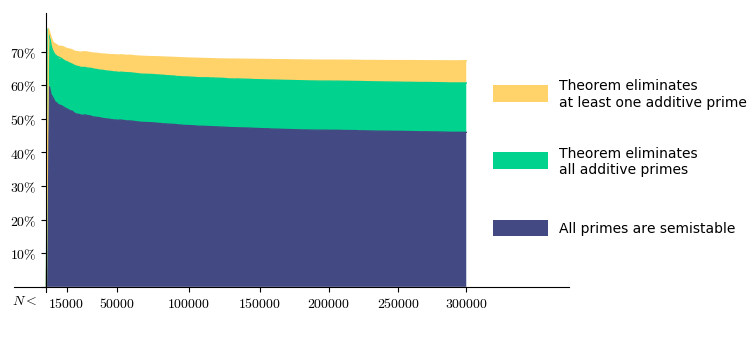

In [9]:
q.set_aspect_ratio(4/5*773429);q

In [4]:
    k_at_2_3 = [k for k in range(len(conductors)) if valuation(conductors[k],2)<2 and valuation(conductors[k],3)<2]
    L2_3 = [L[k] for k in k_at_2_3]                                     
    data2_3 = [data[k] for k in k_at_2_3]                       
    conductors2_3 = [conductors[k] for k in k_at_2_3]
    c1 = lambda x: a1(x,data2_3)
    c1pc2 = lambda x: a1pa2(x,data2_3)
    c1pc2pc3 = lambda x: a1pa2pa3(x,data2_3)

In [9]:
RR(c1pc2pc3(len(data2_3))), RR(c1pc2pc3(len(data2_3)-c1(len(data2_3))))

0.850384050289200

In [82]:
save(q,'plot_semistable_at_2.eps')

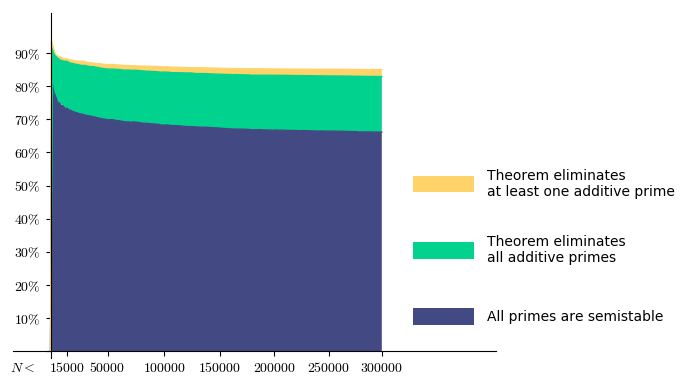

In [35]:
r=produce_plots_at_2_3(537689-1);r.set_aspect_ratio(537689); r

In [36]:
save(r,'plot_semistable_at_2_3.eps')

In [15]:
print [max([k for k in range(len(data_disregard_2_3)) if conductors_odd[k] < a]) for a in [15000,50000,100000,150000,200000,250000,300000]]

[59502, 214200, 437225, 658894, 876913, 1095564, 1311065]


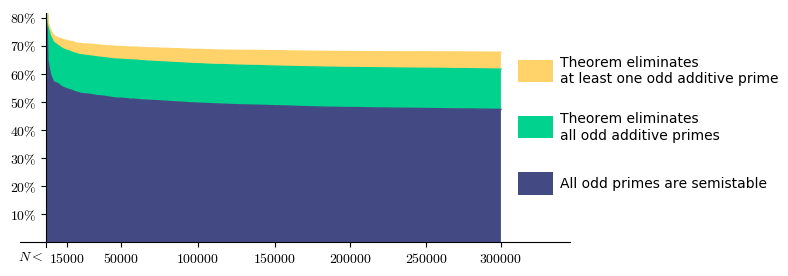

In [134]:
s=produce_plots_odd(len(data_odd)-1);s

In [52]:
    c1 = lambda x: a1(x,data_odd)
    c1pc2 = lambda x: a1pa2(x,data_odd)
    c1pc2pc3 = lambda x: a1pa2pa3(x,data_odd)

In [53]:
RR(c1pc2pc3(len(data_odd))-c1pc2(len(data_odd))), RR(c1pc2(len(data_odd))-c1(len(data_odd))), RR(c1(len(data_odd)))

(0.0603348265191634, 0.143317618397839, 0.473015490436416)

In [135]:
save(s,'plot_odd_primes.eps')

## Next we produce sample files for the data we calculated above, so that we can check that we are doing the right thing

In [142]:
f = open('sample.txt','w')
for k in range(100000,100500):
    f.write('\n {}-th elliptic curve in the set we check\n'.format(k))
    E = EllipticCurve(L[k])
    N = E.conductor()
    m = E.modular_degree()
    f.write('Elliptic curve data: E= {}\n N= {}\n m= {}\n'.format(E.cremona_label(),factor(N),factor(m)))
    if data[k]==0:
        f.write('Conclusion: some divisibility relation')
    if data[k]==1:
        f.write('Conclusion: sqfree')
    if data[k]==2:
        f.write('Conclusion: eliminate_all_additive')
    if data[k]==3:
        f.write('Conclusion: eliminate_one_additive')
    f.write('\n')

In [100]:
f = open('sample_away_from_2.txt','w')
for k in range(1,1000):
    f.write('\n {}-th elliptic curve\n'.format(k))
    E = EllipticCurve(L2[k])
    N = E.conductor()
    m = E.modular_degree()
    f.write('Elliptic curve data: E= {}\n N= {}\n m= {}\n'.format(E.cremona_label(),factor(N),factor(m)))
    if data2[k]==0:
        f.write('Conclusion: some divisibility relation')
    if data2[k]==1:
        f.write('Conclusion: sqfree')
    if data2[k]==2:
        f.write('Conclusion: eliminate_all_additive')
    if data2[k]==3:
        f.write('Conclusion: eliminate_one_additive')
    f.write('\n')

In [88]:
f = open('sample_away_from_2_3.txt','w')
for k in range(10000,11000):
    f.write('\n {}-th elliptic curve\n'.format(k))
    E = EllipticCurve(L2_3[k])
    N = E.conductor()
    m = E.modular_degree()
    f.write('Elliptic curve data: E= {}\n N= {}\n m= {}\n'.format(E.cremona_label(),factor(N),factor(m)))
    if data2_3[k]==0:
        f.write('Conclusion: some divisibility relation')
    if data2_3[k]==1:
        f.write('Conclusion: sqfree')
    if data2_3[k]==2:
        f.write('Conclusion: eliminate_all_additive')
    if data2_3[k]==3:
        f.write('Conclusion: eliminate_one_additive')
    f.write('\n')

In [71]:
f = open('sample_odd.txt','w')
for k in range(100000,100500):
    f.write('\n {}-th elliptic curve in the set we check\n'.format(k))
    E = EllipticCurve(L_odd[k])
    N = E.conductor()
    m = E.modular_degree()
    f.write('Elliptic curve data: E= {}\n N= {}\n m= {}\n'.format(E.cremona_label(),factor(N),factor(m)))
    if data_odd[k]==0:
        f.write('Conclusion: some divisibility relation')
    if data_odd[k]==1:
        f.write('Conclusion: sqfree odd part')
    if data_odd[k]==2:
        f.write('Conclusion: eliminate_all_odd_additive')
    if data_odd[k]==3:
        f.write('Conclusion: eliminate_one_odd_additive')
    f.write('\n')

In [9]:
f = open('sample_disregard_2_3.txt','w')
for k in range(50000,55000):
    f.write('\n {}-th elliptic curve in the set we check\n'.format(k))
    E = EllipticCurve(L[k])
    N = E.conductor()
    m = E.modular_degree()
    f.write('Elliptic curve data: E= {}\n N= {}\n m= {}\n'.format(E.cremona_label(),factor(N),factor(m)))
    if data_disregard_2_3[k]==0:
        f.write('Conclusion: some divisibility relation')
    if data_disregard_2_3[k]==1:
        f.write('Conclusion: sqfree p>3 part')
    if data_disregard_2_3[k]==2:
        f.write('Conclusion: eliminate_all_>3_additive')
    if data_disregard_2_3[k]==3:
        f.write('Conclusion: eliminate_one_>3_additive')
    f.write('\n')

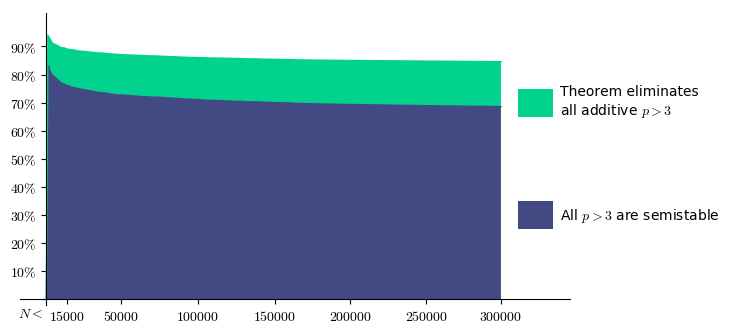

In [103]:
p_disregard_2_3 = produce_plots_disregard_2_3(len(data_disregard_2_3)-1);p_disregard_2_3

In [104]:
save(p_disregard_2_3,'plot_disregard_2_3.eps')

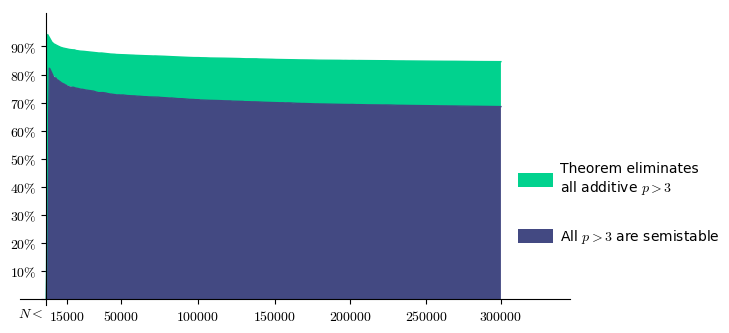

In [ ]:
blue = len(data)*[0]
green = len(data)*[0]
yellow = len(data)*[0]
red = len(data)*[0]
for i in range(1,len(data)):
    clear_output(wait=True)
    display(i,str((i*100)//len(data))+"%")
    blue[i]=blue[i-1] + (data[i]==1)
    green[i]=green[i-1] + (data[i]==1) + (data[i]==2)
    yellow[i]=yellow[i-1] + (data[i]==1) + (data_odd[i]==2)
    red[i]=red[i-1] + (data[i]==1) + (data_disregard_2_3[i]==2)